In [45]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [40]:


path = './dataset/'
lst = []
file_path = []
file_emotion = []

for dir in os.listdir(path):
    actor = os.listdir(path + dir)
    for file in actor:
        part= file.split('.')[0]
        part = part.split('-')

        file_emotion.append(int(part[2]))
        file_path.append(path + dir + '/' + file)

emotions_df = pd.DataFrame(file_emotion , columns = ['Emotions'])
path_df = pd.DataFrame(file_path , columns = ['Path'])

ravdess_df = pd.concat([emotions_df, path_df], axis = 1)
    
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head(10)    




,Emotions,Path
0,calm,./dataset/Actor_09/03-01-02-02-01-01-09.wav
1,surprise,./dataset/Actor_09/03-01-08-02-02-02-09.wav
2,disgust,./dataset/Actor_09/03-01-07-01-02-01-09.wav
3,happy,./dataset/Actor_09/03-01-03-02-01-02-09.wav
4,angry,./dataset/Actor_09/03-01-05-02-01-01-09.wav
5,calm,./dataset/Actor_09/03-01-02-01-02-02-09.wav
6,angry,./dataset/Actor_09/03-01-05-02-02-01-09.wav
7,sad,./dataset/Actor_09/03-01-04-02-02-02-09.wav
8,neutral,./dataset/Actor_09/03-01-01-01-02-02-09.wav
9,sad,./dataset/Actor_09/03-01-04-01-01-02-09.wav


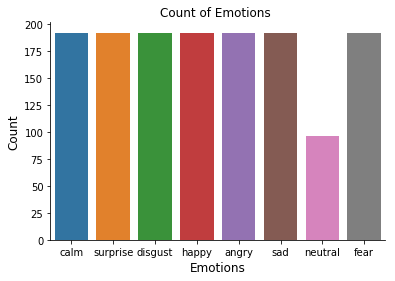

In [79]:
plt.title('Count of Emotions ', size = 12)
sns.countplot(ravdess_df.Emotions)
plt.xlabel('Emotions', size = 12)
plt.ylabel('Count', size = 12)
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

# Data Aug

In [81]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

# Plot waveform and spectogram for emotions 

In [71]:
def create_waveplot(data, sr, e):
    plt.figure(figsize = (10, 3))
    plt.title('Waveplot for audio with emotion {}'.format(e), size = 15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()
    
def create_spectogram(data, sr, e):
    
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize = (12, 3))
    plt.title('Spectogram for audio with emotion {}'.format(e), size = 15)
    librosa.display.specshow(Xdb, sr=sr, x_axis = 'time', y_axis = 'hz')
    plt.colorbar()
    
    

### Fear

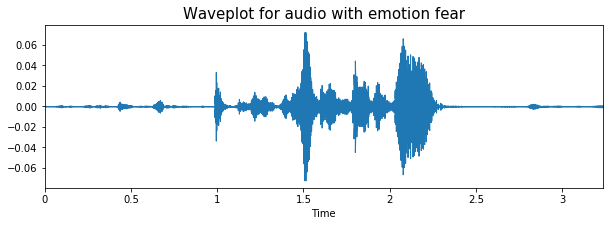

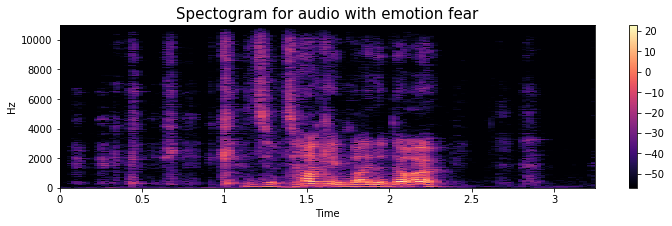

In [68]:
emotion = 'fear'
e_path = np.array(ravdess_df.Path[ravdess_df.Emotions == emotion])[1]
data, sr = librosa.load(e_path)
create_waveplot(data, sr, emotion)
create_spectogram(data, sr, emotion)

### Calm

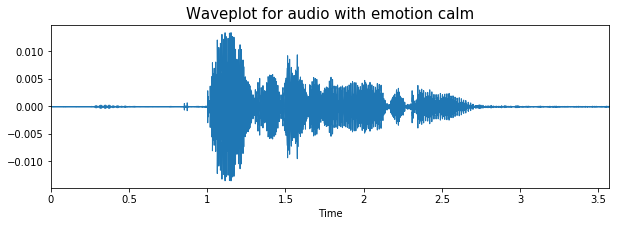

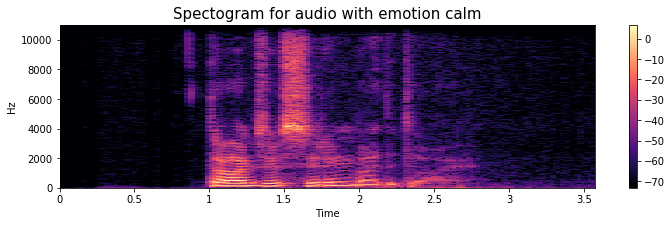

In [72]:
emotion = 'calm'
e_path = np.array(ravdess_df.Path[ravdess_df.Emotions == emotion])[1]
data, sr = librosa.load(e_path)
create_waveplot(data, sr, emotion)
create_spectogram(data, sr, emotion)

### Surprise

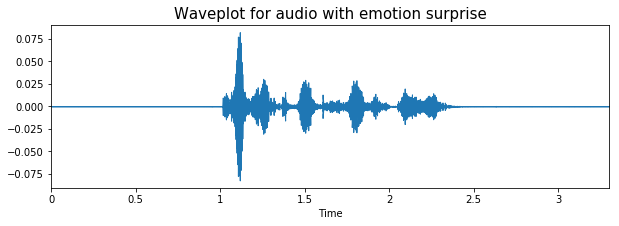

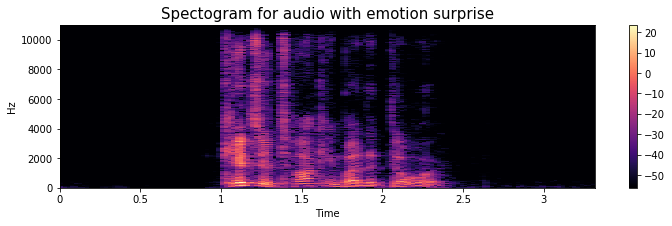

In [75]:
emotion = 'surprise'
e_path = np.array(ravdess_df.Path[ravdess_df.Emotions == emotion])[1]
data, sr = librosa.load(e_path)
create_waveplot(data, sr, emotion)
create_spectogram(data, sr, emotion)

# Feature Extraction 

#### .Zero Crossing Rate
#### .Chroma_stft
#### .MFCC
#### .RMS(root mean square) value
#### .MelSpectogram to train our model.

In [88]:
def extract_features(data):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y = data).T, axis = 0)
    result = np.hstack((result, zcr))
    
    
    
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S = stft, sr = sample_rate).T, axis = 0)
    result = np.hstack((result, chroma_stft))
    
    mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sample_rate).T, axis = 0)
    result = np.hstack((result, mfcc))
    
    
    mel = np.mean(librosa.feature.melspectrogram(y = data, sr = sample_rate).T, axis = 0)
    result = np.hstack((result, mel))
    
    
    return result
    
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result
    

In [89]:
X, Y = [], []
for path, emotion in zip(ravdess_df.Path, ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [97]:
len(X), len(Y), ravdess_df.Path.shape

(4320, 4320, (1440,))

In [99]:
features_df = pd.DataFrame(X)
features_df['labels'] = Y
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,labels
0,0.213890,0.829279,0.851144,0.831212,0.804724,0.724069,0.724679,0.699878,0.705757,0.663494,...,5.364766e-06,0.000006,0.000008,0.000005,0.000003,1.979282e-06,2.564788e-06,1.009175e-06,6.721105e-08,calm
1,0.201836,0.828163,0.840024,0.836429,0.828772,0.787550,0.777089,0.719541,0.718246,0.699358,...,5.355627e-06,0.000006,0.000008,0.000005,0.000003,2.001787e-06,2.578800e-06,1.026139e-06,9.035214e-08,calm
2,0.140998,0.780101,0.803436,0.838905,0.806703,0.764186,0.693222,0.703725,0.711882,0.725134,...,8.849964e-07,0.000001,0.000001,0.000002,0.000001,6.064087e-07,3.824694e-07,7.155289e-08,1.230575e-08,calm
3,0.197410,0.720043,0.706077,0.664547,0.664003,0.645778,0.621153,0.616266,0.691831,0.691411,...,7.297186e-05,0.000068,0.000094,0.000101,0.000115,8.128675e-05,2.594328e-05,6.500259e-06,4.238732e-07,surprise
4,0.277904,0.760636,0.751391,0.726304,0.721266,0.720946,0.670094,0.638459,0.688898,0.697234,...,7.678516e-05,0.000075,0.000103,0.000108,0.000121,8.855010e-05,3.408658e-05,1.414375e-05,7.274401e-06,surprise


# Data Prep

In [101]:
X = features_df.iloc[:, :-1].values
Y = features_df['labels'].values

In [103]:
X

array([[2.13889793e-01, 8.29278883e-01, 8.51143950e-01, ...,
        2.56478756e-06, 1.00917455e-06, 6.72110512e-08],
       [2.01836480e-01, 8.28162645e-01, 8.40024087e-01, ...,
        2.57880029e-06, 1.02613911e-06, 9.03521409e-08],
       [1.40997541e-01, 7.80100600e-01, 8.03435792e-01, ...,
        3.82469444e-07, 7.15528894e-08, 1.23057486e-08],
       ...,
       [1.50625723e-01, 4.76658911e-01, 5.34792188e-01, ...,
        4.15766125e-05, 2.04226130e-05, 1.42414941e-06],
       [2.72777416e-01, 6.30893110e-01, 6.75889224e-01, ...,
        3.37054531e-03, 3.54756547e-03, 3.45161504e-03],
       [1.31712963e-01, 4.50679105e-01, 4.60801880e-01, ...,
        7.56790792e-06, 2.24607871e-06, 1.96888530e-07]])

In [104]:
Y

array(['calm', 'calm', 'calm', ..., 'sad', 'sad', 'sad'], dtype=object)

In [106]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [108]:
X_train, X_test, y_train,y_test = train_test_split(X, Y, random_state = 0, shuffle = True )

In [110]:
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((3240, 161), (1080, 161), (3240, 8), (1080, 8))

In [115]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, X_test.shape

((3240, 161), (1080, 161))

In [116]:
X_train = np.expand_dims(X_train, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)

# Modelling  Sequential

In [118]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 161, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)          

In [121]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 16s 286ms/step - loss: 2.0283 - accuracy: 0.1892 - val_loss: 11.7918 - val_accuracy: 0.2065
Epoch 2/50
51/51 [==============================] - 14s 267ms/step - loss: 1.9210 - accuracy: 0.2398 - val_loss: 17.2397 - val_accuracy: 0.2278
Epoch 3/50
51/51 [==============================] - 14s 267ms/step - loss: 1.8901 - accuracy: 0.2457 - val_loss: 16.5474 - val_accuracy: 0.2241
Epoch 4/50
51/51 [==============================] - 14s 267ms/step - loss: 1.8247 - accuracy: 0.2677 - val_loss: 22.7153 - val_accuracy: 0.1889
Epoch 5/50
51/51 [==============================] - 14s 272ms/step - loss: 1.7631 - accuracy: 0.3122 - val_loss: 35.4848 - val_accuracy: 0.1824
Epoch 6/50
51/51 [==============================] - 13s 263ms/step - loss: 1.7563 - accuracy: 0.3249 - val_loss: 44.7299 - val_accuracy: 0.1620
Epoch 7/50
51/51 [==============================] - 13s 265ms/step - loss: 1.6871 - accuracy: 0.3478 - val_loss: 46.4202 - val_accuracy:

In [126]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

34/34 [==============================] - 1s 35ms/step - loss: 295.9233 - accuracy: 0.1481
Accuracy of our model on test data :  14.814814925193787 %


# Decison Tree Classification

In [14]:
from sklearn.model_selection import train_test_split


In [130]:
X_train, X_test,y_train, y_test = train_test_split(X, Y , test_size = 0.33, random_state = 42)

In [131]:
from sklearn.tree import DecisionTreeClassifier

In [128]:
dtree = DecisionTreeClassifier()

In [132]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [133]:
predictions = dtree.predict(X_test)

In [135]:
from sklearn.metrics import classification_report , confusion_matrix
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.59      0.48      0.53       193
           1       0.53      0.54      0.53       177
           2       0.40      0.40      0.40       197
           3       0.45      0.43      0.44       195
           4       0.37      0.37      0.37       196
           5       0.27      0.35      0.31        82
           6       0.37      0.37      0.37       189
           7       0.43      0.47      0.45       197

   micro avg       0.43      0.43      0.43      1426
   macro avg       0.43      0.43      0.42      1426
weighted avg       0.44      0.43      0.43      1426
 samples avg       0.43      0.43      0.43      1426



# RForest CLF

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [137]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [138]:
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=22000,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [139]:
prediction = rforest.predict(X_test)

In [160]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.60      0.47      0.53       193
           1       0.48      0.34      0.40       177
           2       0.47      0.18      0.26       197
           3       0.53      0.30      0.38       195
           4       0.46      0.26      0.33       196
           5       0.26      0.18      0.21        82
           6       0.41      0.24      0.30       189
           7       0.43      0.25      0.32       197

   micro avg       0.47      0.28      0.36      1426
   macro avg       0.46      0.28      0.34      1426
weighted avg       0.47      0.28      0.35      1426
 samples avg       0.28      0.28      0.28      1426



/home/vaibhav/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# MLP CLF

In [141]:
from sklearn.neural_network import MLPClassifier

In [145]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [146]:
prediction = clf.predict(X_test)

In [147]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.84      0.49      0.62       193
           1       0.73      0.26      0.38       177
           2       0.58      0.15      0.23       197
           3       0.68      0.38      0.49       195
           4       0.68      0.26      0.37       196
           5       0.00      0.00      0.00        82
           6       0.47      0.32      0.38       189
           7       0.80      0.21      0.33       197

   micro avg       0.67      0.28      0.39      1426
   macro avg       0.60      0.26      0.35      1426
weighted avg       0.65      0.28      0.38      1426
 samples avg       0.26      0.28      0.27      1426



/home/vaibhav/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vaibhav/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# KNN CLF

In [157]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [158]:
prediction = neigh.predict(X_test)

In [159]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.60      0.47      0.53       193
           1       0.48      0.34      0.40       177
           2       0.47      0.18      0.26       197
           3       0.53      0.30      0.38       195
           4       0.46      0.26      0.33       196
           5       0.26      0.18      0.21        82
           6       0.41      0.24      0.30       189
           7       0.43      0.25      0.32       197

   micro avg       0.47      0.28      0.36      1426
   macro avg       0.46      0.28      0.34      1426
weighted avg       0.47      0.28      0.35      1426
 samples avg       0.28      0.28      0.28      1426



/home/vaibhav/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
